# Looking at RECS

 Data are the responses from the 2009 Residential Energy Consumption Survey from the EIA: http://www.eia.gov/consumption/residential/
 
 Similar data is available for every four years since 1979

Goal: inform policy makers on where and what type of housing units that can most effectively boost residential energy efficiency in the US.

In [80]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
#import openpyxl

## See public_layout.csv file

In [42]:
pl = pd.DataFrame.from_csv('cap-data/public_layout.csv',index_col=None, 
                            encoding = 'utf-8')

In [43]:
pl.size

4655

## See recs2009_public.csv file

In [44]:
rp = pd.DataFrame.from_csv('cap-data/recs2009_public.csv', index_col = None, encoding = 'utf-8')

In [45]:
rp.head()

,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEEL,KAVALNG,PERIODNG,SCALENG,PERIODLP,SCALELP,PERIODFO,SCALEFO,PERIODKR,SCALEKER
0,1,2,4,12,2,2471.679705,4742,1080,4953,1271,...,0,-2,-2,-2,-2,-2,-2,-2,-2,-2
1,2,4,10,26,2,8599.172010,2662,199,2688,143,...,0,1,1,0,-2,-2,-2,-2,-2,-2
2,3,1,1,1,5,8969.915921,6233,505,5741,829,...,0,3,5,3,-2,-2,-2,-2,-2,-2
3,4,2,3,7,2,18003.639600,6034,672,5781,868,...,3,3,5,3,-2,-2,-2,-2,-2,-2
4,5,1,1,1,3,5999.605242,5388,702,5313,797,...,0,1,1,0,-2,-2,-2,-2,-2,-2


In [77]:
kwh = rp['KWH']
sqft = rp['TOTSQFT_EN']
eui = kwh/sqft
rp['eui']=eui

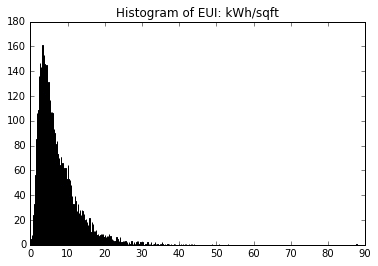

In [83]:
plt.hist(rp.eui,bins = 1000)
plt.title("Histogram of EUI: kWh/sqft")
plt.show()

In [88]:
a = 'sst'
type(a)

str

In [91]:
type(a) == str

True

## See recs2009_public_codebook.xlsx file

In [95]:
# Converted .xlsx to .csv, but is there a way to read in an excel file such that the 
# Response Codes and Labels and Code Descriptions come out cleaner and separated?
pc = pd.DataFrame.from_csv('cap-data/recs2009_public_codebook.csv', index_col = 0, encoding = 'utf-8')
pc['Response Codes and Labels']=[x.split('\r') if type(x) == str else x for x in pc['Response Codes and Labels']]

In [98]:
pc['Code Desciption']=[x.split('\r') if type(x) == str else x for x in pc['Code Desciption']]

In [99]:
pc.head(20)
# Next step: expand table (multiple variable names)

,Variable Description,Response Codes and Labels,Code Desciption
Variable Name,,,
DOEID,Unique identifier for each respondent,[00001 - 12083],[Unique identifier for each respondent]
REGIONC,Census Region,"[1, 2, 3, 4]","[Northeast Census Region, Midwest Census Regio..."
DIVISION,Census Division,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]","[New England Census Division (CT, MA, ME, NH, ..."
REPORTABLE_DOMAIN,Reportable states and groups of states,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[, Connecticut, Maine, New Hampshire, Rhode Is..."
TYPEHUQ,Type of housing unit,"[1, 2, 3, 4, 5]","[Mobile Home, Single-Family Detached, Single-F..."
NWEIGHT,Final sample weight,NaN,[Final sample weight]
HDD65,"Heating degree days in 2009, base temperature 65F",NaN,"[Heating degree days in 2009, base temperature..."
CDD65,"Cooling degree days in 2009, base temperature 65F",NaN,"[Cooling degree days in 2009, base temperature..."
HDD30YR,"Heating degree days, 30-year average 1981-2010...",NaN,"[Heating degree days, 30-year average 1981-201..."


In [48]:
pc.loc['DOEID',]

Variable Description         Unique identifier for each respondent
Response Codes and Labels                            00001 - 12083
Code Desciption              Unique identifier for each respondent
Name: DOEID, dtype: object

In [49]:
np.arange(1979,2009,4)

array([1979, 1983, 1987, 1991, 1995, 1999, 2003, 2007])

# Looking at Largest Dataset for Global Energy Forecasting Competition

In [50]:
lh = pd.DataFrame.from_csv('kaggle-data/Load_history.csv',index_col=None, 
                            encoding = 'utf-8')

In [51]:
lh.head(10)

,zone_id,year,month,day,h1,h2,h3,h4,h5,h6,...,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
0,1,2004,1,1,"16,853","16,450","16,517","16,873","17,064","17,727",...,"13,518","13,138","14,130","16,809","18,150","18,235","17,925","16,904","16,162","14,750"
1,1,2004,1,2,"14,155","14,038","14,019","14,489","14,920","16,072",...,"16,127","15,448","15,839","17,727","18,895","18,650","18,443","17,580","16,467","15,258"
2,1,2004,1,3,"14,439","14,272","14,109","14,081","14,775","15,491",...,"13,507","13,414","13,826","15,825","16,996","16,394","15,406","14,278","13,315","12,424"
3,1,2004,1,4,"11,273","10,415","9,943","9,859","9,881","10,248",...,"14,207","13,614","14,162","16,237","17,430","17,218","16,633","15,238","13,580","11,727"
4,1,2004,1,5,"10,750","10,321","10,107","10,065","10,419","12,101",...,"13,845","14,350","15,501","17,307","18,786","19,089","19,192","18,416","17,006","16,018"
5,1,2004,1,6,"15,742","15,682","16,132","16,761","17,909","20,234",...,"18,762","19,162","21,509","25,314","28,060","28,768","28,919","28,653","27,406","26,507"
6,1,2004,1,7,"26,014","26,447","27,286","27,923","29,130","31,503",...,"20,617","21,013","23,676","27,329","29,685","29,838","29,806","28,704","27,069","25,708"
7,1,2004,1,8,"25,104","25,122","25,464","25,715","26,219","28,552",...,"22,421","22,883","24,436","26,555","27,394","27,486","26,890","25,529","23,869","22,278"
8,1,2004,1,9,"21,175","21,056","21,241","22,062","23,026","25,610",...,"24,955","24,932","25,497","27,668","28,784","28,113","27,311","26,327","24,967","23,824"
9,1,2004,1,10,"23,405","23,507","24,067","24,786","25,418","26,631",...,"22,257","22,457","23,909","27,515","29,526","30,073","30,858","30,698","30,208","30,056"


In [52]:
bench = pd.DataFrame.from_csv('kaggle-data/Benchmark.csv',index_col=None, 
                            encoding = 'utf-8')
bench.head(10)

,id,zone_id,year,month,day,h1,h2,h3,h4,h5,...,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
0,1,1,2005,3,6,20505,19445,19373,18833,19962,...,14333,13606,14009,15133,16097,16949,16895,16322,14969,14016
1,2,2,2005,3,6,167016,163275,164618,164731,165840,...,145182,140364,141993,148293,151031,158234,162813,158044,148985,140408
2,3,3,2005,3,6,180211,176174,177624,177745,178942,...,156652,151453,153210,160008,162963,170735,175675,170530,160756,151501
3,4,4,2005,3,6,530,496,489,460,492,...,497,472,479,512,535,542,552,536,468,415
4,5,5,2005,3,6,8585,8346,8564,8638,8793,...,6835,6486,6679,7343,7723,8347,8536,7856,6816,5974
5,6,6,2005,3,6,175595,171615,173042,173362,174626,...,152016,146850,148671,155635,158753,166581,171347,165898,155800,146381
6,7,7,2005,3,6,180211,176174,177624,177745,178942,...,156652,151453,153210,160008,162963,170735,175675,170530,160756,151501
7,8,8,2005,3,6,4053,3844,3712,3862,3905,...,3582,3514,3561,3791,3923,4004,4178,3877,3335,3014
8,9,9,2005,3,6,70026,70123,69860,70153,69489,...,73839,74779,74334,74948,73531,71714,71620,71917,72211,72957
9,10,10,2005,3,6,23703,22995,22716,22552,22575,...,24053,23565,23809,25044,26522,27685,27703,26618,24646,22665


In [53]:
temphist = pd.DataFrame.from_csv('kaggle-data/temperature_history.csv',index_col=None, 
                            encoding = 'utf-8')
temphist.head(10)

,station_id,year,month,day,h1,h2,h3,h4,h5,h6,...,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
0,1,2004,1,1,46,46,45,41,39,35,...,55.0,55.0,52.0,46.0,40.0,40.0,39.0,38.0,40.0,41.0
1,1,2004,1,2,43,44,46,46,47,47,...,54.0,56.0,57.0,53.0,50.0,47.0,46.0,45.0,45.0,45.0
2,1,2004,1,3,45,46,46,44,43,46,...,69.0,68.0,68.0,65.0,64.0,63.0,62.0,63.0,63.0,62.0
3,1,2004,1,4,63,62,62,62,60,60,...,71.0,72.0,71.0,68.0,67.0,67.0,65.0,64.0,65.0,64.0
4,1,2004,1,5,64,63,65,64,64,64,...,66.0,66.0,66.0,66.0,63.0,54.0,52.0,49.0,47.0,47.0
5,1,2004,1,6,47,46,45,43,41,41,...,46.0,46.0,45.0,39.0,39.0,39.0,38.0,36.0,32.0,32.0
6,1,2004,1,7,30,29,28,28,28,26,...,31.0,31.0,31.0,30.0,30.0,30.0,29.0,31.0,30.0,30.0
7,1,2004,1,8,29,26,24,22,22,22,...,36.0,35.0,35.0,34.0,35.0,35.0,37.0,35.0,35.0,34.0
8,1,2004,1,9,33,33,32,31,31,32,...,33.0,33.0,33.0,31.0,31.0,31.0,30.0,29.0,27.0,26.0
9,1,2004,1,10,24,22,21,20,19,19,...,22.0,20.0,20.0,20.0,18.0,18.0,18.0,18.0,18.0,18.0


In [54]:
subtemp = pd.DataFrame.from_csv('kaggle-data/submission_template.csv',index_col=None, 
                            encoding = 'utf-8')
subtemp.head(10)

,id,zone_id,year,month,day,h1,h2,h3,h4,h5,...,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
0,1,1,2005,3,6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2,2005,3,6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,3,2005,3,6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,4,2005,3,6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,5,2005,3,6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,6,6,2005,3,6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7,7,2005,3,6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,8,8,2005,3,6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,9,9,2005,3,6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,10,10,2005,3,6,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
test = pd.DataFrame.from_csv('kaggle-data/test.csv',index_col=None, 
                            encoding = 'utf-8')
test.head(10)

,id,zone_id,year,month,day,weight
0,768,12,2006,5,26,1
1,93,9,2005,3,10,1
2,547,1,2005,12,30,1
3,479,17,2005,12,26,1
4,239,8,2005,6,24,1
5,382,4,2005,9,14,1
6,1200,3,2008,7,2,8
7,267,15,2005,6,25,1
8,295,1,2005,9,10,1
9,379,1,2005,9,14,1


In [57]:
weights = pd.DataFrame.from_csv('kaggle-data/weights.csv',index_col=None, 
                            encoding = 'utf-8')
weights.head(10)

,id,zone_id,year,month,day,h1,h2,h3,h4,h5,...,h15,h16,h17,h18,h19,h20,h21,h22,h23,h24
0,1,1,2005,3,6,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1,2,2,2005,3,6,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
2,3,3,2005,3,6,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
3,4,4,2005,3,6,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,5,5,2005,3,6,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
5,6,6,2005,3,6,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
6,7,7,2005,3,6,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
7,8,8,2005,3,6,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
8,9,9,2005,3,6,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
9,10,10,2005,3,6,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [85]:
a = 3
x = 1 if a < 3 else 5

In [86]:
x

5